In [751]:
# todo list
# method of moments optimization

In [763]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gamma, beta
from scipy.integrate import dblquad, cumulative_trapezoid
from scipy.stats import gaussian_kde, norm
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline



import importlib

import base, bivariate, marginals, utils, tests, plots, mixture, total

importlib.reload(base)
importlib.reload(utils)
importlib.reload(bivariate)
importlib.reload(marginals)
importlib.reload(tests)
importlib.reload(plots)
importlib.reload(mixture)
importlib.reload(total)


plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 75


In [764]:
def generate_bivariate_cdf_function(X, Y, pdf_values):

    #print(pdf_values)
    
    row_sums = np.empty_like(pdf_values)
    cdf_vals = np.empty_like(pdf_values) 
    
    # assume symmetric grid
    x_range = X[0]
    
    for i in range(X.shape[0]):
        row_sums[i, :] = cumulative_trapezoid(pdf_values[i], x_range, initial = 0)
        
    for j in range(X.shape[1]):
        cdf_vals[:, j] = cumulative_trapezoid(row_sums[:, j], x_range, initial = 0)
        
    cdf_vals /= np.max(cdf_vals)

    # Create an interpolation function for the CDF values
    cdf_interpolator = RectBivariateSpline(x_range, x_range, cdf_vals)

    # Return a function that uses the interpolator to evaluate the CDF at any given point (x, y)
    def cdf_function(x, y):
        return cdf_interpolator(x, y, grid=False)

    return cdf_vals



In [819]:
copula = bivariate.NormalMixture(p1 = 0.75, Q! = 0.9, p2 = 0.5, Q2 = -0.25)

In [820]:
print(copula.summary())

                           Bivariate Copula Summary                           
Model Name:                   Mixture   Log-Likelihood:                    nan
Model Family:              Elliptical   AIC:                               nan
Method:                           MLE   BIC:                               nan
Num. Params:                        4   Kendall's Tau:                     nan
Num. Obs:                         nan   Spearman's Rho:                    nan
Date:                Sat, Feb 24 2024   Upper Tail Depend.:             0.0000
Time:                        20:58:55   Lower Tail Depend.:             0.0000
                                                                              
                                                           Parameter Estimatess                                                          
             coef  std err       h0        t    P>|t| 95% Conf. Int.
--------------------------------------------------------------------


In [811]:
u1, u2 = utils.get_u_grid()

In [812]:
cdf = copula.cdf(u1, u2)
pdf = copula.pdf(u1, u2)

<AxesSubplot:>

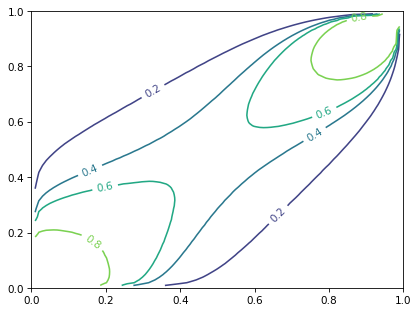

In [813]:
plots.copula_contour(copula, pdf)

<AxesSubplot:>

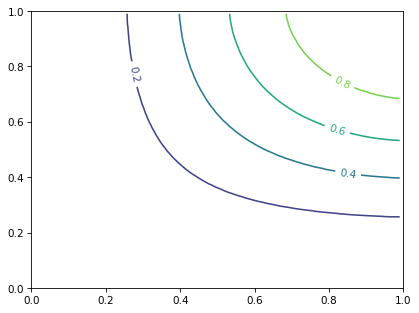

In [814]:
plots.copula_contour(copula, cdf)

<AxesSubplot:>

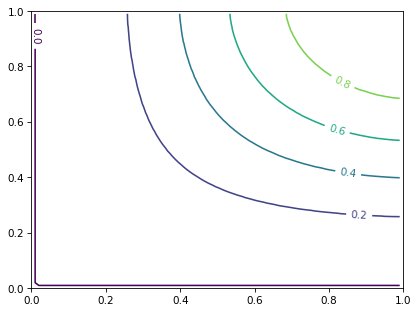

In [815]:
cdf2 = generate_bivariate_cdf_function(u1, u2, pdf)
plots.copula_contour(copula, cdf2)

In [816]:
copula._conditional_quantile(0.001, 0.95, 1.5)

0.7194509557515896

<AxesSubplot:>

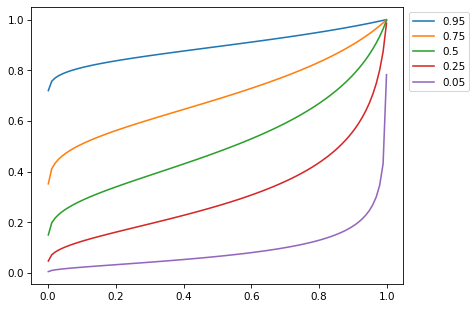

In [817]:
plots.copula_quantile_curves(copula)

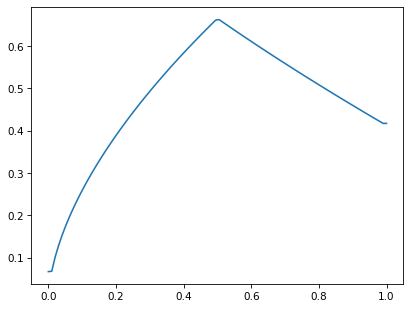

In [818]:
#plots.copula_quantile_curves(copula)
q_range = utils.get_u_range(adj = 1e-4)

plt.plot(q_range, copula.quantile_dependance(q_range, adj = 1e-2))

In [109]:
#f, ax = plt.subplots(subplot_kw = {"projection": "3d"})
#ax.plot_surface(U1, U2, pdf, cmap = "viridis", antialiased = False)
#ax.view_init(25, 20)

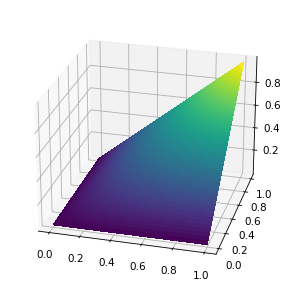

In [110]:
f, ax = plt.subplots(subplot_kw = {"projection": "3d"})
ax.plot_surface(U1, U2, cdf, cmap = "viridis", antialiased = False)
ax.view_init(25, -75)

In [189]:

    #return cdf_vals

In [190]:
U1, U2 = utils.get_u_grid(adj = 1e-5, range_num = 200)

#cdf = copula.cdf(U1, U2)

In [191]:
pdf1 = copula.pdf(U1, U2)
pdf2 = copula.pdf(1 - U1, U2)

In [194]:
f1 = generate_bivariate_cdf_function(U1, U2, pdf1)
f2 = generate_bivariate_cdf_function(U1, U2, pdf2)



In [195]:
print(f1(0.5, 0.5))

print(f2(0.5, 0.5))

0.33419529078758764
0.16580470921240828


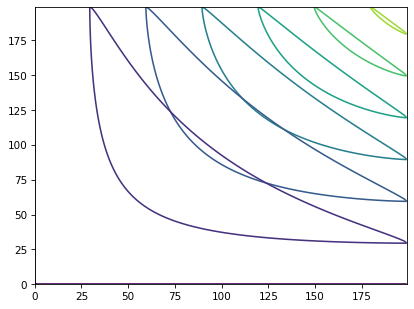

In [196]:
f, ax = plt.subplots()
ax.contour(cdf1)
ax.contour(cdf2)

#ax.plot_surface(U1, U2, cdf1, color = "tab:blue", antialiased = False, alpha = 0.5)
#ax.plot_surface(U1, U2, cdf2, color = "tab:red", antialiased = False, alpha = 0.5)

#ax.view_init(25, -75)

In [885]:
#u1, u2 = copula.simulate(n = 2_000)

#f, ax = plt.subplots()
#ax.scatter(u1, u2, alpha = 0.5)

In [886]:
#copula2 = bivariate.NormalMixture()
#gamma1, gamma2 = copula2._e_step(u1, u2, 0.75, 0.25, -0.5, 0.5)


#results = copula2._m_step(u1, u2, gamma1, gamma2, -0.5, 0.5)
#results = copula2.fit(u1, u2, initial_params_guess = None, n_init = 10)

In [887]:
copula = bivariate.Normal()
print(copula.summary())

                           Bivariate Copula Summary                           
Model Name:                    Normal   Log-Likelihood:                    nan
Model Family:              Elliptical   AIC:                               nan
Method:                          CMLE   BIC:                               nan
Num. Params:                        1   Kendall's Tau:                  0.0000
Num. Obs:                         nan   Spearman's Rho:                 0.0000
Date:                Mon, Feb 19 2024   Upper Tail Depend.:             0.0000
Time:                        20:55:37   Lower Tail Depend.:             0.0000
                                                                              
                            Parameter Estimatess                           
             coef    std err       h0          t       P>|t| 95% Conf. Int.
---------------------------------------------------------------------------
Q          0.0000        nan     0.00        nan         nan 

<AxesSubplot:>

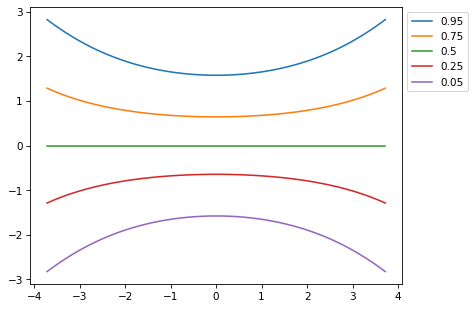

In [198]:
model = total.BivariateModel(copula = bivariate.StudentsT(Q = 0, df = 10), 
                             marginal1 = marginals.Normal(), 
                             marginal2 = marginals.Normal())

plots.model_quantile_curves(model)

In [421]:
#ax = plots.quantile_dependance(u1_sim, u2_sim, copula = copula, copula_label = "StudentsT Model", 
#                               show_indep = True, boot = True)

In [199]:
#marginal1 = marginals.StandardSkewedT(eta = 30, lam = 0.5)


#x_range = utils.get_x_range()
#u_range = utils.get_u_range()

#plt.plot(x_range, marginal1.pdf(x_range))
#plt.plot(x_range, marginal1.cdf(x_range))
#plt.plot(u_range, marginal1.ppf(u_range))

In [267]:
#marginal2 = marginals.StandardSkewedT()
marginal2 = marginals.StandardSkewedT()

data = marginal1.simulate(seed = 1, n = 1000)
marginal2.fit(data, robust_cov = True)

print(marginal2.summary())

[[nan nan]
 [nan nan]]
                       Marginal Distribution Summary                       
Model Name:           SkewedStudentsT   Log-Likelihood:                 nan
Method:                           MLE   AIC:                            nan
Num. Params:                        2   BIC:                            nan
Num. Obs:                        1000                                      
Date:                Sun, Feb 11 2024                                      
Time:                        19:04:33                                      
                                                                           
                                                                           
                            Parameter Estimates                             
              coef    std err       h0          t       P>|t| 95% Conf. Int.
----------------------------------------------------------------------------
eta      1093.3656        nan    30.00        nan         nan 

In [263]:
#marginal2 = marginals.StandardSkewedT()
marginal2 = marginals.Normal()

data = marginal1.simulate(seed = 1, n = 1000)
marginal2.fit(data, robust_cov = True)

print(marginal2.summary())

                       Marginal Distribution Summary                       
Model Name:                    Normal   Log-Likelihood:          -1426.3500
Method:                           MLE   AIC:                      1430.3500
Num. Params:                        2   BIC:                      2866.5156
Num. Obs:                        1000                                      
Date:                Sun, Feb 11 2024                                      
Time:                        19:03:26                                      
                                                                           
                                                                           
                             Parameter Estimates                              
             coef    std err       h0          t       P>|t|    95% Conf. Int.
------------------------------------------------------------------------------
mu         0.0169     0.0319     0.00     0.5292      0.5968 [-0.0457, 0.0794]


In [235]:
#model = bivariate.StudentT(df = 5, Q = 0.7)
#model = bivariate.BivariateNormalMix(Q1 = 0.5, Q2 = -0.25, p = 0.1, adj = 1e-2)
model1 = bivariate.StudentsT(Q = 0.5, df = 10)
#model2 = bivariate.Normal(Q = 0.5)

#model = bivariate.Clayton(alpha = 0.5)
#model = bivariate.Gumbel(delta = 1)

#model1 = bivariate.Normal(Q = 0.3)

In [37]:
#u1_sim, u2_sim = bivariate.StudentT(df = 5, Q = 0.9).simulate(n = 10000)

#model = bivariate.Gumbel(delta = 1.5)
#u1_sim, u2_sim = model2.simulate(n = 500)

#model2 = bivariate.StudentT()
#model2.fit(u1_sim, u2_sim)

u1_sim, u2_sim = model1.simulate(n = 500)

model2 = bivariate.StudentsT()
model2.fit(u1_sim, u2_sim)

In [38]:
print(model2.summary())

                           Bivariate Copula Summary                           
Model Name:                 StudentsT   Log-Likelihood:                78.3465
Model Family:              Elliptical   AIC:                          -74.3465
Method:                          CMLE   BIC:                         -144.2638
Num. Params:                        2   Kendall's Tau:                  0.3534
Num. Obs:                         500   Spearman's Rho:                    nan
Date:                Sun, Feb 11 2024   Upper Tail Depend.:                 NA
Time:                        11:24:04   Lower Tail Depend.:                 NA
                                                                              
                                                                              
                               Parameter Estimates                               
             coef    std err       h0          t       P>|t|       95% Conf. Int.
----------------------------------------------

In [39]:
#q_range = utils.get_u_range(5e-2, range_num = 100)

#f, ax = plt.subplots()
#ax.plot(q_range, np.where(q_range > 0.5, 1 - q_range, q_range))

#Q = -0.5
#models = [bivariate.Clayton(alpha = 0.5),
#          bivariate.Clayton(alpha = 1)]


#for model in models:
#    ax.plot(q_range, model.quantile_dependance(q_range))
    


In [40]:
#ax = plots.quantile_dependance(u1_sim, u2_sim, copula = model1, copula_label = "StudentsT Model", 
#                               show_indep = True, boot = True)

In [41]:
#print(model2.summary())

In [42]:
#marginal1 = marginals.StudentT(mean = 2, stdev = 1)
#x1 = marginal1.simulate(n = 1000)


#marginal2 = marginals.StudentT()
#marginal2.fit(x1)

In [43]:
#print(marginal2.summary())

In [44]:
#copula = bivariate.Clayton(alpha = 0.5)
#u1, u2 = utils.get_u_grid()

In [45]:
#plots.copula_3d_surf(copula, adj = 3e-2, azim = 150, elev = 30, cmap = "inferno")

In [46]:
#plots.copula_contour(copula, num_levels = 5)

In [47]:
#ax = plots.copula_quantile_curves(copula)

In [48]:
data = np.random.normal(size = 150)

In [49]:
marginal = marginals.GaussianKDE()

marginal.fit(data)

In [50]:
print(marginal.summary())

                       Marginal Distribution Summary                       
Model Name:               GaussianKDE   Bandwidth                    0.3671
Method:                         scott   Log-Likelihood:           -220.1374
Num. Params:                        1   AIC:                            nan
Num. Obs:                         150   BIC:                            nan
Date:                Sun, Feb 11 2024                                      
Time:                        11:24:09                                      
                                                                           
                                                                           


In [51]:
marginal = marginals.GaussianKDE()
marginal.fit(data)


x_range = np.linspace(np.min(data), np.max(data))

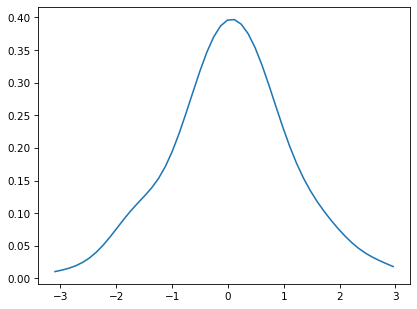

In [52]:
plt.plot(x_range, marginal.pdf(x_range))

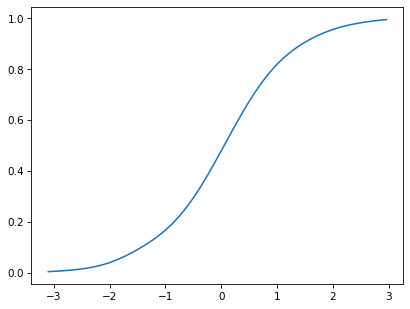

In [53]:
plt.plot(x_range, marginal.cdf(x_range))

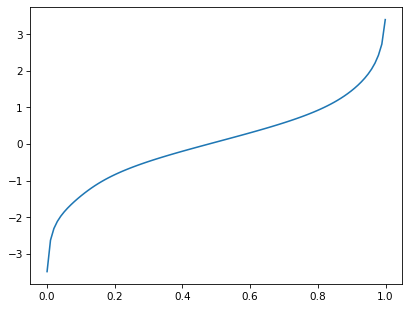

In [54]:
plt.plot(utils.get_u_range(), marginal.ppf(utils.get_u_range()))

In [177]:
marginal.ppf(0.999)

array(18.63322863)

In [240]:
def f(*params):
    return "Hello"

In [132]:
# Compute CDF by cumulatively summing the PDF values and normalizing
cdf_values = np.cumsum(pdf_values)
cdf_values /= cdf_values[-1]



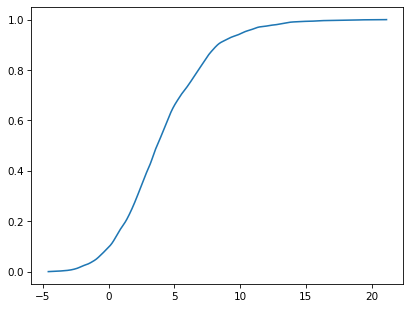

In [133]:
plt.plot(x_range, cdf_values)

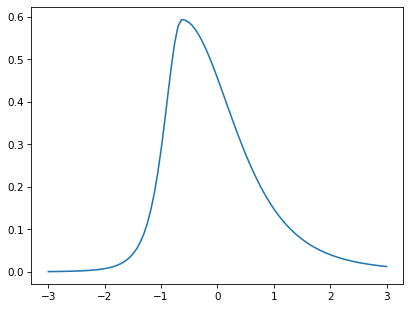

In [367]:
def skew_gen_t_pdf(x, mu, sigma, lam, p, q):
    
    # common terms
    beta_term1 = beta(1/p, q)
    beta_term2 = beta(2/q, q - 1/p)
    
    # v variable
    v1 = np.power(q, -1/p)
    v2 = 1 + 3 * np.power(lam, 2)
    v3 = beta(3/p, q - 2/p) / beta_term1
    v4 = (4 * np.power(lam, 2)) * np.power(beta_term2 / beta_term1, 2)
    v = v1 / np.sqrt(v2 * v3 - v4)
    
    
    # m variable
    sigma_term = 2 * sigma * v * np.power(q, 1/p)
    m = lam * sigma_term * beta_term2 / beta_term1
    
    
    # the final pdf
    x_term = x - mu + m
    pdf1 = sigma_term * beta_term1
    pdf2 = np.power(np.abs(x_term), p)
    pdf3 = q * np.power(v * sigma, p) * np.power(1 + lam * np.sign(x_term), p)
    
    fx = p / (pdf1 * np.power(1 + pdf2 / pdf3, 1/p + q))
    
    return fx
    
    
pdf2 = skew_gen_t_pdf(x_range, 0, 1, 0.5, 2, 2)
plt.plot(x_range, pdf2)



In [396]:
def find_x_bounds(loc, scale, pdf_func, *pdf_params, tol = 5e-4, expansion_factor = 0.5):
    
    
    step = expansion_factor * scale
    left_bound = -3 * scale + loc; right_bound = 3 * scale + loc

    
    while True:
        
        pdf_right = pdf_func(right_bound, *pdf_params)[0]
        pdf_left = pdf_func(left_bound, *pdf_params)[0]
        
        if pdf_left > tol:
            left_bound -= step
        
        if pdf_right > tol:
            right_bound += step
            
        print(left_bound, right_bound)
        if pdf_left < tol and pdf_right < tol:
            return left_bound, right_bound
        
        
loc = 0
scale = 1
df = 5
pdf_func = stats.t.pdf

find_x_bounds(loc, scale, pdf_func, [df, loc, scale])

-3.5 3.5
-4.0 4.0
-4.5 4.5
-5.0 5.0
-5.5 5.5
-6.0 6.0
-6.5 6.5
-6.5 6.5


(-6.5, 6.5)

In [397]:
np.linspace(-6, 6, 1000)

array([-6.        , -5.98798799, -5.97597598, -5.96396396, -5.95195195,
       -5.93993994, -5.92792793, -5.91591592, -5.9039039 , -5.89189189,
       -5.87987988, -5.86786787, -5.85585586, -5.84384384, -5.83183183,
       -5.81981982, -5.80780781, -5.7957958 , -5.78378378, -5.77177177,
       -5.75975976, -5.74774775, -5.73573574, -5.72372372, -5.71171171,
       -5.6996997 , -5.68768769, -5.67567568, -5.66366366, -5.65165165,
       -5.63963964, -5.62762763, -5.61561562, -5.6036036 , -5.59159159,
       -5.57957958, -5.56756757, -5.55555556, -5.54354354, -5.53153153,
       -5.51951952, -5.50750751, -5.4954955 , -5.48348348, -5.47147147,
       -5.45945946, -5.44744745, -5.43543544, -5.42342342, -5.41141141,
       -5.3993994 , -5.38738739, -5.37537538, -5.36336336, -5.35135135,
       -5.33933934, -5.32732733, -5.31531532, -5.3033033 , -5.29129129,
       -5.27927928, -5.26726727, -5.25525526, -5.24324324, -5.23123123,
       -5.21921922, -5.20720721, -5.1951952 , -5.18318318, -5.17

In [305]:
np.min(np.random.exponential(scale = 0.5, size = 1000))

0.00018082025006242345

In [16]:
n = 10

w = np.random.dirichlet(np.ones(n))

C = np.ones((n, n))

print(w @ C @ w)

W1, W2 = np.meshgrid(w, w)

print(np.sum(W1 * W2 * C))

0.9999999999999997
0.9999999999999998
